In [37]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold

#nltk.download('vader_lexicon')
#load all the wsb_* files
#stocks = ["GME", "AMC", "TSLA", "PLTR", "MSFT", "BBBY", "SPY", "AAPL"]#, "BB"
stocks = ['AAPL', 'AMC', 'BBBY', 'GME', 'MSFT', 'PLTR', 'SPY', 'TSLA']
data_plots = []
Best_inputs = {}
Best_accuracies = {}
Best_y_preds = []
Best_feature_importances = []

In [38]:
#from google.colab import drive
#drive.mount('/content/drive/')
#dirpath = '/content/drive/MyDrive/FT5005/GW_dataset/'
dirpath=''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
# Loop for all stocks
# This takes quite a long time, I saved the output variables, we can directly use them and skip this long step.
import warnings
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
pd.options.mode.chained_assignment = None

for istock in range(len(stocks)):
  print(f'############################################### {stocks[istock]} ###############################################')
  stock = stocks[istock]
  df_stock_price = pd.read_csv(dirpath + f"yahoo stock data/{stock}.csv")
  df_collated = pd.read_csv(dirpath + f"Collated/collated_{stock}.csv")

  # Convert 'date' feature into date type
  df_stock_price['Date'] = pd.to_datetime(df_stock_price['date'], format='%Y-%m-%d').dt.date
  df_sortedbyDate_stock_price = df_stock_price.sort_values(by='Date').dropna(subset=['Date'], inplace=False)

  # get the columns we need
  df_collated['Date'] = pd.to_datetime(df_collated['date'], format='%Y-%m-%d').dt.date

  df_collated_dataset = df_collated[['Date','ticker','volume', 'labels_shifted', 'score', 'sentiment_score','capital_letter_ratio','profanity_count','emoji_count','capital_letter_count','post_length']]
  df_collated_dataset['dif_price'] = df_collated['close']-df_collated['open']
  #All_features = ['dif_price','volume', 'score', 'sentiment_score','capital_letter_ratio','profanity_count','emoji_count','capital_letter_count','post_length','price_t-1','price_t-2']
  # Get the price of t-lag_t
  # for example, if the date_t-1 is not working day, then we'll find the latest work date as date_t-1
  # if date_t-1 and date_t-2 are not working days, date_t-1 will be the latest work date, t-2 will be one day ahead of date_t-1

  def get_previous_price(date, df_stock_price, lag_t):
    count = lag_t
    lag_date = date
    while count > 0:
      lag_date = lag_date - datetime.timedelta(days=1)
      if lag_date not in df_stock_price['Date'].values:
        continue
      else:
        count -= 1

    return df_stock_price.loc[df_stock_price['Date'] == lag_date]['close'].values[0]

  # get price_t-1 and price_t-2
  df_collated_dataset['price_t-1'] = df_collated_dataset['Date'].apply(lambda x: get_previous_price(x, df_sortedbyDate_stock_price,1))
  df_collated_dataset['price_t-2'] = df_collated_dataset['Date'].apply(lambda x: get_previous_price(x, df_sortedbyDate_stock_price,2))
  y_test = df_collated_dataset['labels_shifted'][int(df_collated_dataset['labels_shifted'].shape[0] * 0.8):]
  Output = pd.DataFrame(data=y_test)
  Output.index = df_collated_dataset['Date'][int(df_collated_dataset['Date'].shape[0] * 0.8):]
  
  HP = ['price_t-1', 'price_t-2']
  HP_V = ['price_t-1', 'price_t-2','volume']
  HP_V_TF = ['price_t-1', 'price_t-2','volume','sentiment_score','capital_letter_ratio','profanity_count','emoji_count','capital_letter_count','post_length']
  All_features = ['dif_price','volume', 'score', 'sentiment_score','capital_letter_ratio','profanity_count','emoji_count','capital_letter_count','post_length','price_t-1','price_t-2']
  
  Input_features = [HP, HP_V, HP_V_TF, All_features]
  Best_input = []
  Best_accuracy = 0
  
  for i in range(len(Input_features)):
    input_feature = Input_features[i]
    X = df_collated_dataset[input_feature]
    Y = df_collated_dataset['labels_shifted']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

    param_grid = {
        'n_estimators': range(350,500,30),
        'max_depth': range(3,6),
        'learning_rate':[0.003, 0.005, 0.007, 0.1, 0.2, 0.3]
    }

    # Perform grid search with 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    #print('Report the best parameters and rmse for best result:')
    #print('Grid Search Best Parameters: ', grid_search.best_params_)
    #print('Grid Search Best accuracy: ', grid_search.best_score_)

    best_grid_model = grid_search.best_estimator_

    y_pred = best_grid_model.predict(X_test)
    #print(classification_report(y_test, y_pred))
    Output['Input'+str(i)] = y_pred

    # Calculate the RMSE for each model
    pre_accuracy_score = accuracy_score(y_test, y_pred)
    if pre_accuracy_score > Best_accuracy:
      Best_accuracy = pre_accuracy_score
      Best_input = input_feature
      Best_y_pred = pd.DataFrame(y_pred, index = Output.index)
      Best_feature_importance = best_grid_model.feature_importances_

    #print("Predicted accuracy score:", pre_accuracy_score)

  # Store the best input features for this stock
  if Best_input == HP:
    Best_inputs[stocks[istock]] = 'Historical Price'
  elif Best_input == HP_V:
    Best_inputs[stocks[istock]] = 'Historical Price + Volume'
  elif Best_input == HP_V_TF:
    Best_inputs[stocks[istock]] = 'Historical Price + Volume + Text Features'
  elif Best_input == All_features:
    Best_inputs[stocks[istock]] = 'All Features'
  Best_accuracies[stocks[istock]] = Best_accuracy
  Best_y_preds.append(Best_y_pred)
  Best_feature_importances.append(Best_feature_importance)

  
  print(f"The best input features of stock {stocks[istock]} is : {Best_inputs[stocks[istock]]}.")
  print("Predicted accuracy score:", Best_accuracy)
  print("Classification report:")
  print(classification_report(y_test, y_pred))
  print('##############################################################################################')

  # add random
  np.random.seed(42)
  random_numbers = np.random.random(size=Output.shape[0])
  binary_numbers = np.where(random_numbers >= 0.5, 1, 0)
  Output['Random'] = binary_numbers

  # add buy and hold
  Output['Buy and hold'] = [1 for _ in range(Output.shape[0])]

  # add close price and open price
  Output['Close'] = df_collated['close'][int(df_collated_dataset['labels_shifted'].shape[0] * 0.8):].values
  Output['Open'] = df_collated['open'][int(df_collated_dataset['labels_shifted'].shape[0] * 0.8):].values

  # get cumulative return data
  def tradeByML(Period, predictions):
    DelPrices = [0]
    position = 0
    in_price = Output['Open'].iloc[0]
    accDelPri = 0 #accumulative dleta price
    for t in range(Period-1):
      #if holding
      if position == 1:
        # if the signal shows sell
        if predictions[t] == 0:
          tDelPrice = accDelPri + (Output.iloc[t]['Close'] - in_price)
          accDelPri = tDelPrice
          position = 0
        else:
          tDelPrice = accDelPri + (Output.iloc[t]['Close'] - in_price)
      #if not holding
      else:
        # if the signal shows buy
        if predictions[t] == 1: 
          in_price = Output.iloc[t]['Close'] #update buy in price
          tDelPrice = accDelPri + Output.iloc[t]['Close'] - in_price
          position = 1
        else:
          tDelPrice = accDelPri
      DelPrices.append(tDelPrice)
    # if at the moment still holding
    if position == 1:
      tDelPrice = accDelPri + (Output.iloc[Period-1]['Close'] - in_price)
    else:
      tDelPrice = accDelPri
    DelPrices.append(tDelPrice)
    return DelPrices[1:]
  data_plot = pd.DataFrame(index = Output.index)
  for i in range(len(Input_features)+3):

    data_profit = tradeByML(Output.shape[0], Output.iloc[:,i])
    data_plot[Output.columns[i]] = data_profit
  data_plot
  data_plot.columns = ['Original Labels',
                      'Historcial Price',
                      'HP+Volume',
                      'HP+V+Text Features',
                      'All features',
                      'Random',
                      'Buy and Hold']
  data_plots.append(data_plot)


############################################### AAPL ###############################################
The best input features of stock AAPL is : All Features.
Predicted accuracy score: 0.5327102803738317
Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.54      0.52        50
         1.0       0.57      0.53      0.55        57

    accuracy                           0.53       107
   macro avg       0.53      0.53      0.53       107
weighted avg       0.54      0.53      0.53       107

##############################################################################################
############################################### AMC ###############################################
The best input features of stock AMC is : Historical Price.
Predicted accuracy score: 0.5981308411214953
Classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.76      0.64        63
         1.0   

In [40]:
import pickle

# save needed variables
# then we can read them directly to save time
with open(dirpath+'data_plots.pkl', 'wb') as f:
    pickle.dump(data_plots, f)

with open(dirpath+'Best_inputs.pkl', 'wb') as f:
    pickle.dump(Best_inputs, f)

with open(dirpath+'Best_accuracies.pkl', 'wb') as f:
    pickle.dump(Best_accuracies, f)

with open(dirpath+'Best_y_preds.pkl', 'wb') as f:
    pickle.dump(Best_y_preds, f)
    
with open(dirpath+'Best_feature_importances.pkl', 'wb') as f:
    pickle.dump(Best_feature_importances, f)


In [41]:
import pickle

# read variables from local files
#stocks = ["GME", "AMC", "TSLA", "PLTR", "MSFT", "BBBY", "SPY", "AAPL"]
with open(dirpath+'data_plots.pkl', 'rb') as f:
    data_plots = pickle.load(f)

with open(dirpath+'Best_inputs.pkl', 'rb') as f:
    Best_inputs = pickle.load(f)

with open(dirpath+'Best_accuracies.pkl', 'rb') as f:
    Best_accuracies = pickle.load(f)

with open(dirpath+'Best_y_preds.pkl', 'rb') as f:
    Best_y_preds = pickle.load(f)

with open(dirpath+'Best_feature_importances.pkl', 'rb') as f:
    Best_feature_importances = pickle.load(f)

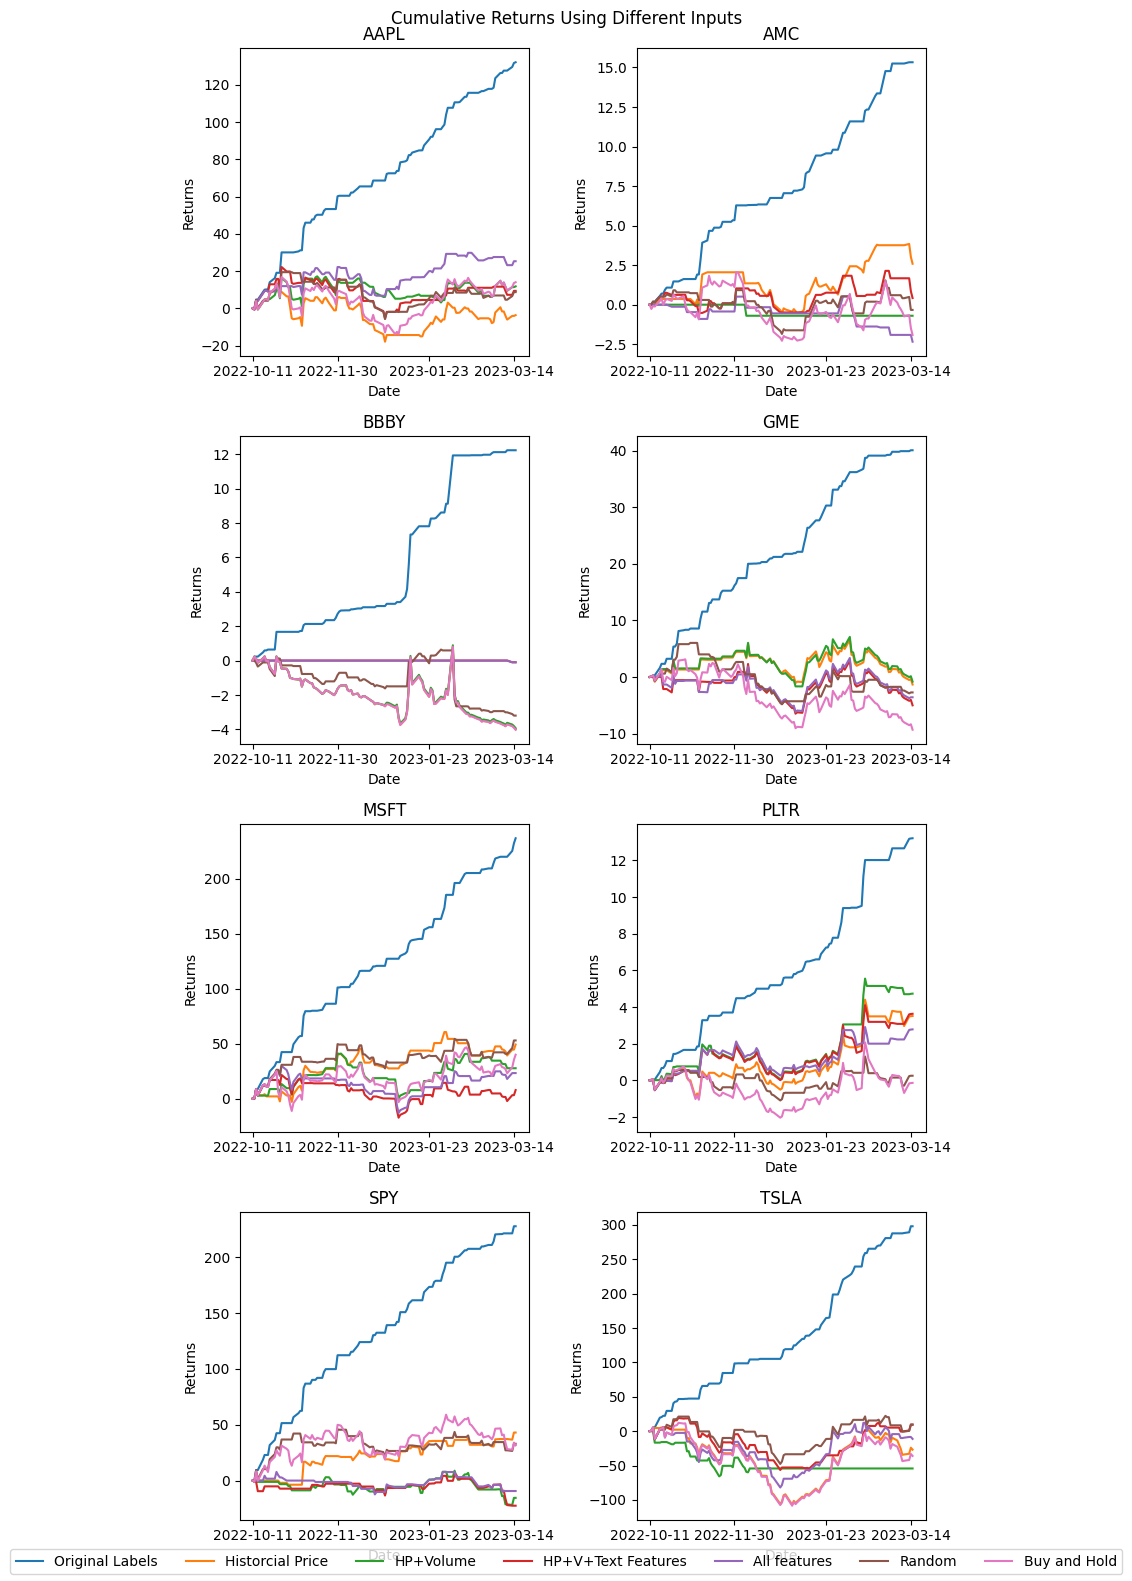

In [42]:
# Line plot cumulative returns
#data_plots[0],data_plots[1],data_plots[2],data_plots[3],data_plots[4],data_plots[5],data_plots[6],data_plots[7] = \
#data_plots[7],data_plots[1],data_plots[5],data_plots[0],data_plots[4],data_plots[3],data_plots[6],data_plots[2]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))

for i, df in enumerate(data_plots):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    df.plot(ax=ax, legend=False)
    ax.set_title(stocks[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.set_xticks((df.index[::int(len(df.index)/3)]))

fig.suptitle("Cumulative Returns Using Different Inputs")
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))

plt.tight_layout()

plt.show()

In [43]:
for key,value in dict(sorted(Best_inputs.items())).items():
  print(key,": ",value)

AAPL :  All Features
AMC :  Historical Price
BBBY :  Historical Price + Volume + Text Features
GME :  All Features
MSFT :  Historical Price
PLTR :  Historical Price
SPY :  Historical Price
TSLA :  Historical Price + Volume + Text Features


In [44]:
print('Best Accuracies:')
for key,value in dict(sorted(Best_accuracies.items())).items():
  print(key,": ",value)
print('\nAverage Best Accuracy:',np.mean(list(Best_accuracies.values())))

Best Accuracies:
AAPL :  0.5327102803738317
AMC :  0.5981308411214953
BBBY :  0.6448598130841121
GME :  0.514018691588785
MSFT :  0.5420560747663551
PLTR :  0.5981308411214953
SPY :  0.5327102803738317
TSLA :  0.5514018691588785

Average Best Accuracy: 0.5642523364485981


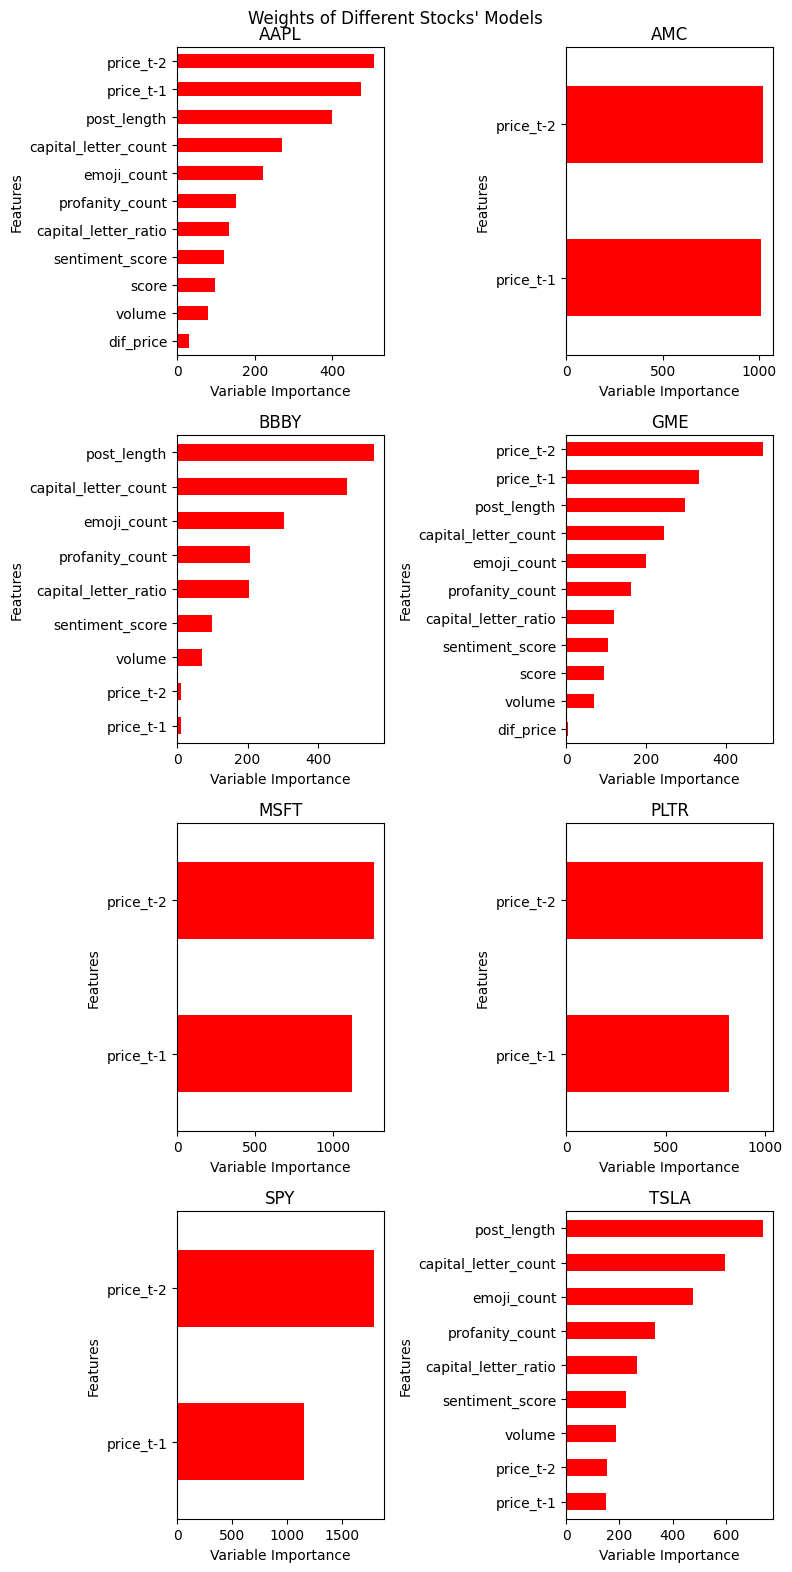

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))

for i, df in enumerate(Best_feature_importances):

    if Best_inputs[stocks[i]] == 'Historical Price':
      x_label = HP
    elif Best_inputs[stocks[i]] == 'Historical Price + Volume':
      x_label = HP_V
    elif Best_inputs[stocks[i]] == 'Historical Price + Volume + Text Features':
      x_label = HP_V_TF
    elif Best_inputs[stocks[i]] == 'All Features':
      x_label = All_features
    
    row = i // 2
    col = i % 2
    ax = axes[row, col]
#################################################################################
    df = pd.DataFrame({'Importance':df}, index=x_label)
    df = df.sort_values('Importance', axis=0, ascending=True).plot(ax=ax, kind='barh', color='r',legend=False)
    #plt.xlabel('Variable Importance')
#################################################################################
    
    #ax.barh(range(len(x_label)), df,color='r')
    ax.set_title(stocks[i])
    ax.set_ylabel('Features')
    ax.set_xlabel('Variable Importance')
    if Best_inputs[stocks[i]] == 'Historical Price':
      x_label = HP
    elif Best_inputs[stocks[i]] == 'Historical Price + Volume':
      x_label = HP_V
    elif Best_inputs[stocks[i]] == 'Historical Price + Volume + Text Features':
      x_label = HP_V_TF
    elif Best_inputs[stocks[i]] == 'All Features':
      x_label = All_features

    ax.set_yticks(range(len(x_label)))
    ax.set_yticklabels([f'{j}' for j in x_label])

fig.suptitle("Weights of Different Stocks' Models")
handles, labels = axes[0][0].get_legend_handles_labels()

plt.tight_layout()

plt.show()